# Local Max Batch Theory
This was initially a theory investigation for optimal batches under vopt. It now just demonstrates the use of greedy batches together with random batch initializations and local max batch initializations. The moons dataset runs faster but isn't interesting. Change to the MNIST_VAE dataset for more interesting results. 

## This code is depracated. 
Initial testing with this was comparing vopt local maxes where you first use LM and then do a greedy procedure to optimize the vopt objective. Then I compared with just doing LM. Original results showed that there wasn't much improvement to be gained by doing the greedy procedure after. This suggests that LM is nearly optimal for vopt. The current implementation does the greedy vopt procedure from a random initial batch. 

## Need to update the code to reflect the changes made. 
## Or I could just add to the bal.py file
## Or just remove this file

In [1]:
import graphlearning.active_learning as al
import graphlearning as gl
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import timeit
import batch_active_learning as bal

## User Input

In [2]:
#Exactly one of the following should be True
use_moons     = False
use_MNIST_VAE = True

#Can disable this if you want
np.random.seed(123)

## Functions / Values

In [3]:
#Values
X = []
labels = []

## Load Moons

In [4]:
if use_moons:
    X,labels = datasets.make_moons(n_samples=1000,noise=0.1)

## Load MNIST VAE

In [5]:
if use_MNIST_VAE:
    X, labels = gl.datasets.load("mnist", metric='vae')

    # class_inds = np.array([2,5,8])
    class_inds = np.arange(10)
    mask = [labels[i] in class_inds for i in range(len(labels))]
    new_labels = labels[mask]

    sub_inds = gl.trainsets.generate(new_labels, rate = 1500)

    X = X[mask][sub_inds]
    labels = new_labels[sub_inds]
    copy_labels = labels.copy()

    for i in range(len(class_inds)):
        labels[copy_labels == class_inds[i]] = i

## Create Graph Learning objects

In [6]:
W = gl.weightmatrix.knn(X,10)
G = gl.graph(W)
train_ind = gl.trainsets.generate(labels, rate=1)
coreset = bal.coreset_dijkstras(G, .5, data = X, density_info = (True, .2, 1.0), initial=list(train_ind));
print("Coreset = ", coreset)

model = gl.ssl.laplace(W)
acq = al.v_opt()
act = al.active_learning(W, coreset, labels[coreset], eval_cutoff=200)
act.candidate_inds = np.setdiff1d(act.training_set, coreset)

Coreset =  [48, 2603, 3664, 5559, 7312, 7784, 9014, 11650, 13385, 13835, 4369, 6849, 13516, 14438, 6059, 10877, 12793, 477, 8392, 9289, 1374, 2385, 13606, 5050, 3543, 12888, 3431, 10068, 12843, 10706, 5997, 5757, 14776, 7805, 8086, 822, 12947, 11547, 5057, 3577, 3300, 13282, 6173, 11847, 3317, 4099, 5619, 9836, 8601, 12896, 8492]


## Run Batch AL Functions

In [7]:
#test_batch1 = [1, 2]
max_new_samples = 1
test_batch1, _, _ = bal.coreset_run_experiment(X, labels, W, coreset, num_iter=max_new_samples, method='Laplace',
                           display=False, use_prior=False, al_mtd='local_max', debug=True,
                           acq_fun='vopt', knn_data=None, mtd_para=(np.inf, 0))
this_batch_size = min(len(test_batch1), 10)
batch_used = np.setdiff1d(test_batch1, coreset)[:this_batch_size]

scores_list1 = []
scores_list2 = []

if use_moons:
    _, _, scores_list1 = bal.vopt_greedy_batch(X, labels, act, acq, model, 
                          batch_size = 10, display = False)

_, _, scores_list2 = bal.vopt_greedy_batch(X, labels, act, acq, model, 
                      given_batch = batch_used, display = False)


Active learning setup time =  15.41952225
Batch Active Learning time =  0.10610770800000324
Batch inds: [2984 1894 2347 2869 2813]
Model fit time =  0.31449662499999675
Iteration: 0 Iteration time =  0.42069750000000283


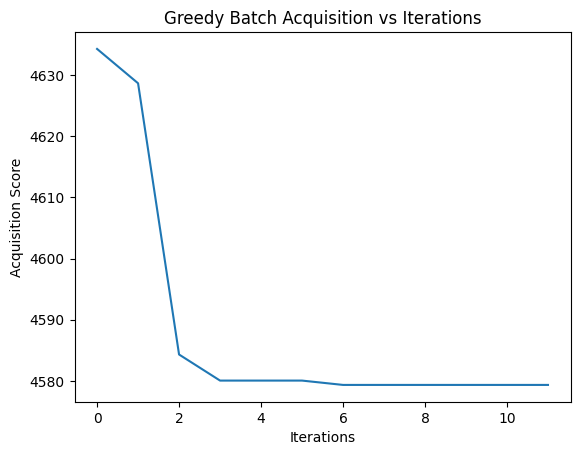

In [8]:
if use_moons:
    plt.plot(np.arange(len(scores_list1)), scores_list1)
    plt.plot(np.arange(len(scores_list2)), scores_list2)
    #plt.plot(np.arange(len(scores_list3)), scores_list3)
    plt.legend(["Random initial", "LM initial"])
else:
    plt.plot(np.arange(len(scores_list2)), scores_list2)
plt.title("Greedy Batch Acquisition vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Acquisition Score")
plt.show()

## Doing Multiple Batches
Notice that the batch sizes are different for Greedy local max (GLM) and local max (LM). The GLM tends to set up the batch in a way that better separates the data. This leads to more local maxes down the line which results in larger batch sizes. 

The timing in debug mode will be updated in the future and isn't the most informative right now. Model fitting is fast, but greedy batch optimization is slow. 

In [9]:
max_new_samples = 5
print("Greedy-LM Batch")
start = timeit.default_timer()

lab_ind1, num_labels1, acc_list1 = bal.coreset_run_experiment(X, labels, W, coreset, num_iter=max_new_samples, method='Laplace',
                           display=False, use_prior=False, al_mtd='greedy_lm', debug=True,
                           acq_fun='vopt', knn_data=None, mtd_para=(np.inf, 0))
end = timeit.default_timer()
print(f"Total Time = {end - start}")
print("LM Batch")
start = timeit.default_timer()
lab_ind2, num_labels2, acc_list2 = bal.coreset_run_experiment(X, labels, W, coreset, num_iter=max_new_samples, method='Laplace',
                           display=False, use_prior=False, al_mtd='local_max', debug=True,
                           acq_fun='vopt', knn_data=None, mtd_para=(np.inf, 0))
end = timeit.default_timer()
print(f"Total Time = {end - start}")

Greedy-LM Batch
Active learning setup time =  21.922702166
Batch Active Learning time =  5.693331874999998
Batch inds: [9810 2984 1704 2358 2347]
Model fit time =  0.2844534999999979
Iteration: 0 Iteration time =  5.9778902500000015
Batch Active Learning time =  3.102062708999995
Batch inds: [6337 8221 2983 2362  799]
Model fit time =  0.28949749999999597
Iteration: 1 Iteration time =  3.391647374999991
Batch Active Learning time =  7.169688292000004
Batch inds: [ 9577 10865 11408  2886 14473]
Model fit time =  0.29064887500000225
Iteration: 2 Iteration time =  7.460449417000007
Batch Active Learning time =  4.198620790999996
Batch inds: [1865 9818 2585  175 2307]
Model fit time =  0.2774954589999936
Iteration: 3 Iteration time =  4.476202915999991
Batch Active Learning time =  4.096511332999995
Batch inds: [ 7028  4432 14087 10289  3041]
Model fit time =  0.2691810000000032
Iteration: 4 Iteration time =  4.366529666999995
Total Time = 48.654101708000006
LM Batch
Active learning setup 

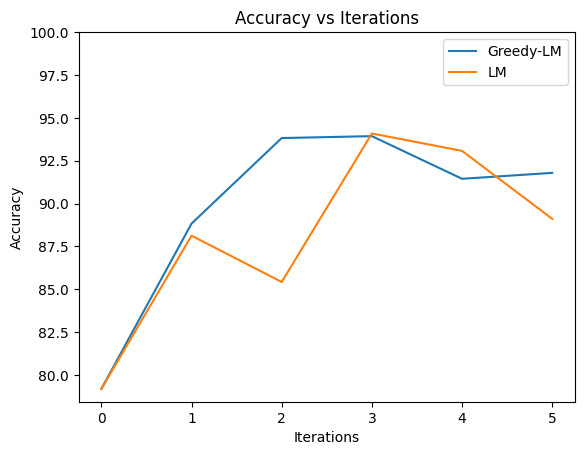

In [10]:
plt.plot(np.arange(len(acc_list1)), acc_list1)
plt.plot(np.arange(len(acc_list2)), acc_list2)
plt.legend(["Greedy-LM", "LM"])
plt.title("Accuracy vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.ylim((None, 100))
#plt.savefig("MNIST GLM vs LM batch2.jpg")
plt.show()

In [11]:
GLM_max = round(np.max(acc_list1), 1)
LM_max = round(np.max(acc_list2), 1)
print("Max GLM = {}%\nMax  LM = {}%".format(GLM_max, LM_max))

Max GLM = 93.9%
Max  LM = 94.1%


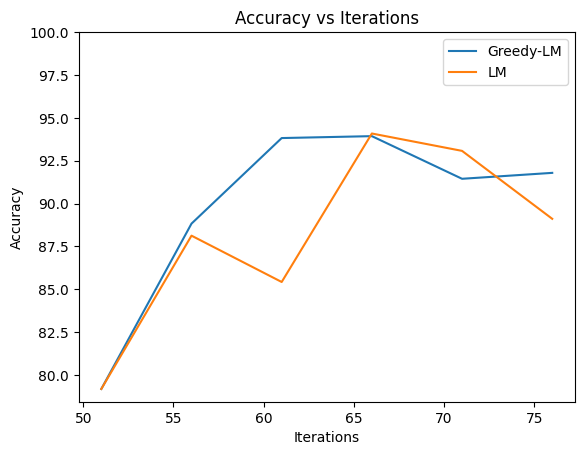

In [12]:
plt.plot(num_labels1, acc_list1)
plt.plot(num_labels2, acc_list2)
plt.legend(["Greedy-LM", "LM"])
plt.title("Accuracy vs Iterations")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.ylim((None, 100))
#plt.savefig("MNIST GLM vs LM batch.jpg")
plt.show()

In [13]:
print(num_labels1)
print(num_labels2)

[51, 56, 61, 66, 71, 76]
[51, 56, 61, 66, 71, 76]
